## Neural Networks
<br>  
**Objectives**  

- Develop an understanding of feed forward and recurrent neural networks
- Implement neural network architecture
- Develop dynamic forecasting skills
- Develop Python skills

**quick review of lec10**
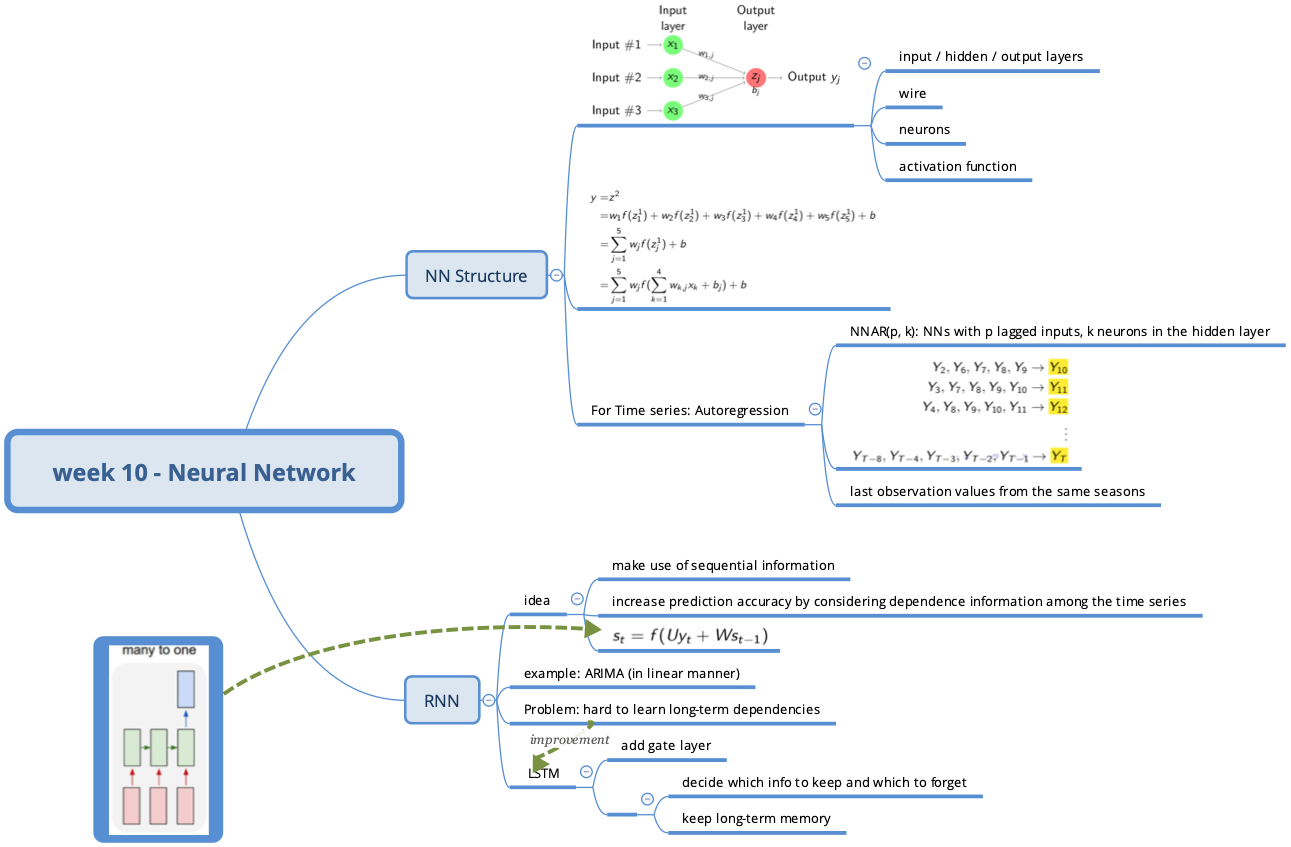

In this tutorial we will take a timeseries, split it into train and test sets then produce <span class="girk">one-step</span> and <span class="girk">dynamic forecasts</span> using both a <span class="mark">feed forward neural network</span> and a <span class="mark">recurrent (LSTM) neural network</span>.

### 1.	Install `Keras` 

For this tutorial you will need to install the `Keras` library.

`Keras` provides a very high level approach to build, train and predict using neural networks. It is built on top of other neural network libraries like `TensorFlow` or `Theano`. It helps to prototype neural networks very quickly.

If you do not have `Keras` installed already you can type the following on the Windows Command Prompt or Terminal on OS X

>conda install –c conda-forge keras

If you have trouble with install the `Keras` package, you can refer to the installation guideline on Canvas or the official online tutorial: https://github.com/keras-team/keras 

## PART 1. Data Preparation

### 2. Import required libraries/functions and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers.core import Dense 
from keras.models import Sequential

# ignore warning
import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [2]:
# set figsize
from pylab import rcParams
rcParams['figure.figsize'] = 16,6

Set the RNG seed so we get the same results every time.
>np.random.seed(1)

Make sure to convert the pandas dataframe to an array by using `.values` attribute. `Keras` expects array data type, not dataframe or series.

In [3]:
data = pd.read_csv('AirPassengers.csv', usecols=[1])
data = data.dropna()  # Drop all Nans
data = data.values

### 3.	Plot the time series

Please complete this yourself. What can you tell me about the data?

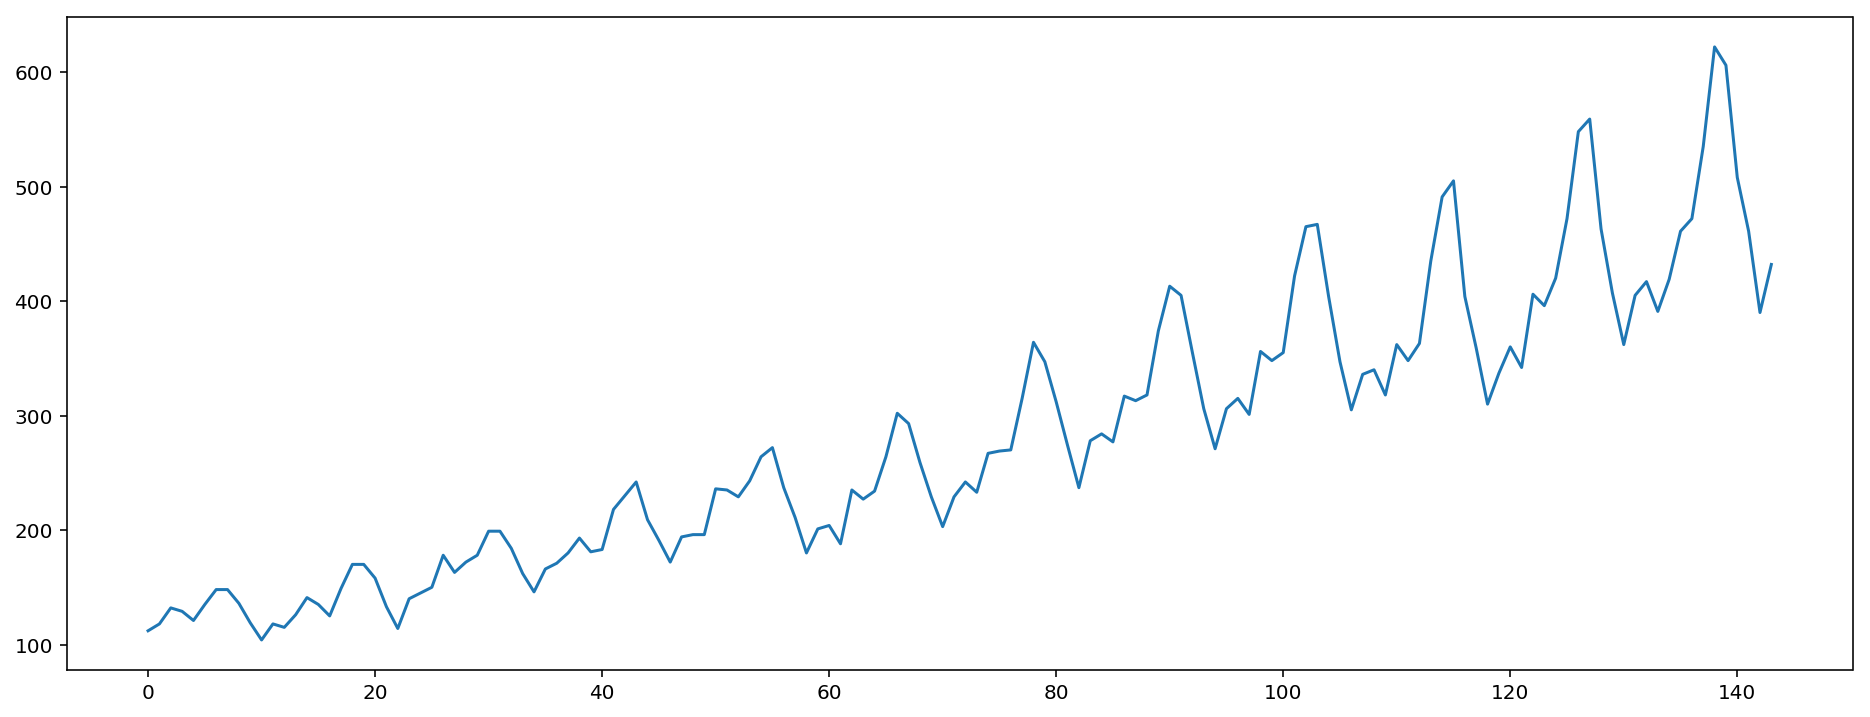

In [4]:
plt.plot(data);

### 4.	Pre-processing (Scaling)
Neural networks normally work best with scaled data, especially when we use the **sigmoid** or **tanh** activation function. It is best practice to scale the data to the range of [0,1]. This can be easily done by using  `MinMaxScaler()` function from `scikit-learn`.

$$scaler = \frac{x - min}{max - min}$$

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

### 5.	Create training and testing features

We must design appropriate **targets** (predictions) and **features** (predictors) for our neural network.

We know that since we are dealing with time series data our target is a single point (scalar value) for the next observation.

The obvious choice for features is the most recent observations in the time series. In other words, in our neural network we will use <span class="mark">a small number of past observations to predict a single new observation</span>.

How many past observations should we use to predict a new observation? The length of this window depends on a few things. First we must consider whether there is seasonality in our data. If there is then to model the seasonality in our network the <span class="girk">input feature windows must be at least as long as the seasonal period</span>. In this dataset the seasonal period is 12 months. In general the more data you can input into your neural network the more accurate the predictions will become. However increasing the amount of data also increases training time and memory requirements. So we must make a trade-off.

We also need to split our data into training and testing components. Later we will train our network on the training set (first 80% of time series) then produce a forecast over the test set (last 20%) and evaluate the accuracy.

In [7]:
# define window size = 12
time_window = 12

# prepare (X, y)
Xall, Yall = [], []
# transform to groups of inputs (according to window size)
for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])

# Convert list to array   
Xall = np.array(Xall)    
Yall = np.array(Yall)     

# set training : test = 80% : 20%
# in this case we have 105:27 samples
train_size = int(len(Xall) * 0.8)
test_size = len(Xall) - train_size

# split training set
Xtrain = Xall[:train_size, :] # shape = (105, 12)
Ytrain = Yall[:train_size]    # shape = (105,)
# split test set
Xtest = Xall[-test_size:, :]  # shape = (27, 12)
Ytest = Yall[-test_size:]     # shape = (27,)

## PART 2. Conventional feed forward Neural Network

### 6.	Define the Feed Forward NN model

Now it is time to define the structure of our Neural Network. We first try a standard <span class="girk">feed forward network architecture</span>. To define a feed forward network we set the model type to be Sequential.

In [13]:
model = Sequential()

# add two layers (1 hidden + 1 output)
model.add(Dense(20, input_dim = time_window, activation = 'relu'))
model.add(Dense(1))

### 7.	Compile

The next step is to compile, which means to check the network for potential errors and to decide on a <span class="girk">loss function</span> (the type of penalty applied to the error) and the <span class="girk">optimization algorithm</span>.

In [14]:
# loss function: MSE
# optimization method: ADAM
model.compile(loss = 'mean_squared_error', optimizer = 'adam') 
# you can try some other choice, according to your task's requirement
# For more detailed explanation, please refer to https://keras.io/models/model/ 

### 8.	Train NN

Finally, we can train our network. By training we mean to learn the <span class="mark">optimal weights</span> of the network edges (links between neurons).

To train we must specify some training **features** (predictors, called `Xtrain`) and **targets** (predictions, called `Ytrain`) and some other **tuning parameters** which will be explained later.

In [15]:
np.random.seed(1)

model.fit(Xtrain, Ytrain, 
          epochs = 100, 
          batch_size = 2, 
          verbose = 2, 
          validation_split = 0.05) # use 95% for training and 5% for testing

Train on 99 samples, validate on 6 samples
Epoch 1/100
 - 0s - loss: 0.1812 - val_loss: 0.3964
Epoch 2/100
 - 0s - loss: 0.0401 - val_loss: 0.1378
Epoch 3/100
 - 0s - loss: 0.0158 - val_loss: 0.0911
Epoch 4/100
 - 0s - loss: 0.0125 - val_loss: 0.0592
Epoch 5/100
 - 0s - loss: 0.0109 - val_loss: 0.0510
Epoch 6/100
 - 0s - loss: 0.0088 - val_loss: 0.0429
Epoch 7/100
 - 0s - loss: 0.0074 - val_loss: 0.0408
Epoch 8/100
 - 0s - loss: 0.0067 - val_loss: 0.0241
Epoch 9/100
 - 0s - loss: 0.0056 - val_loss: 0.0241
Epoch 10/100
 - 0s - loss: 0.0048 - val_loss: 0.0163
Epoch 11/100
 - 0s - loss: 0.0041 - val_loss: 0.0133
Epoch 12/100
 - 0s - loss: 0.0034 - val_loss: 0.0097
Epoch 13/100
 - 0s - loss: 0.0031 - val_loss: 0.0113
Epoch 14/100
 - 0s - loss: 0.0028 - val_loss: 0.0063
Epoch 15/100
 - 0s - loss: 0.0025 - val_loss: 0.0073
Epoch 16/100
 - 0s - loss: 0.0023 - val_loss: 0.0072
Epoch 17/100
 - 0s - loss: 0.0021 - val_loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0020 - val_loss: 0.0036
Epoch 19/100

### 9.	One-Step Forecast

We can first check how well the model fits our data by doing a one-step prediction. This uses all available observations i.e. feeds the neural network with actual observations and we ask for its prediction.

This is also known as an <span class="girk">in-sample forecast</span>.

In [16]:
# predict all y values and transform back to normal scale
allPredict = model.predict(Xall)
allPredictPlot = scaler.inverse_transform(allPredict)

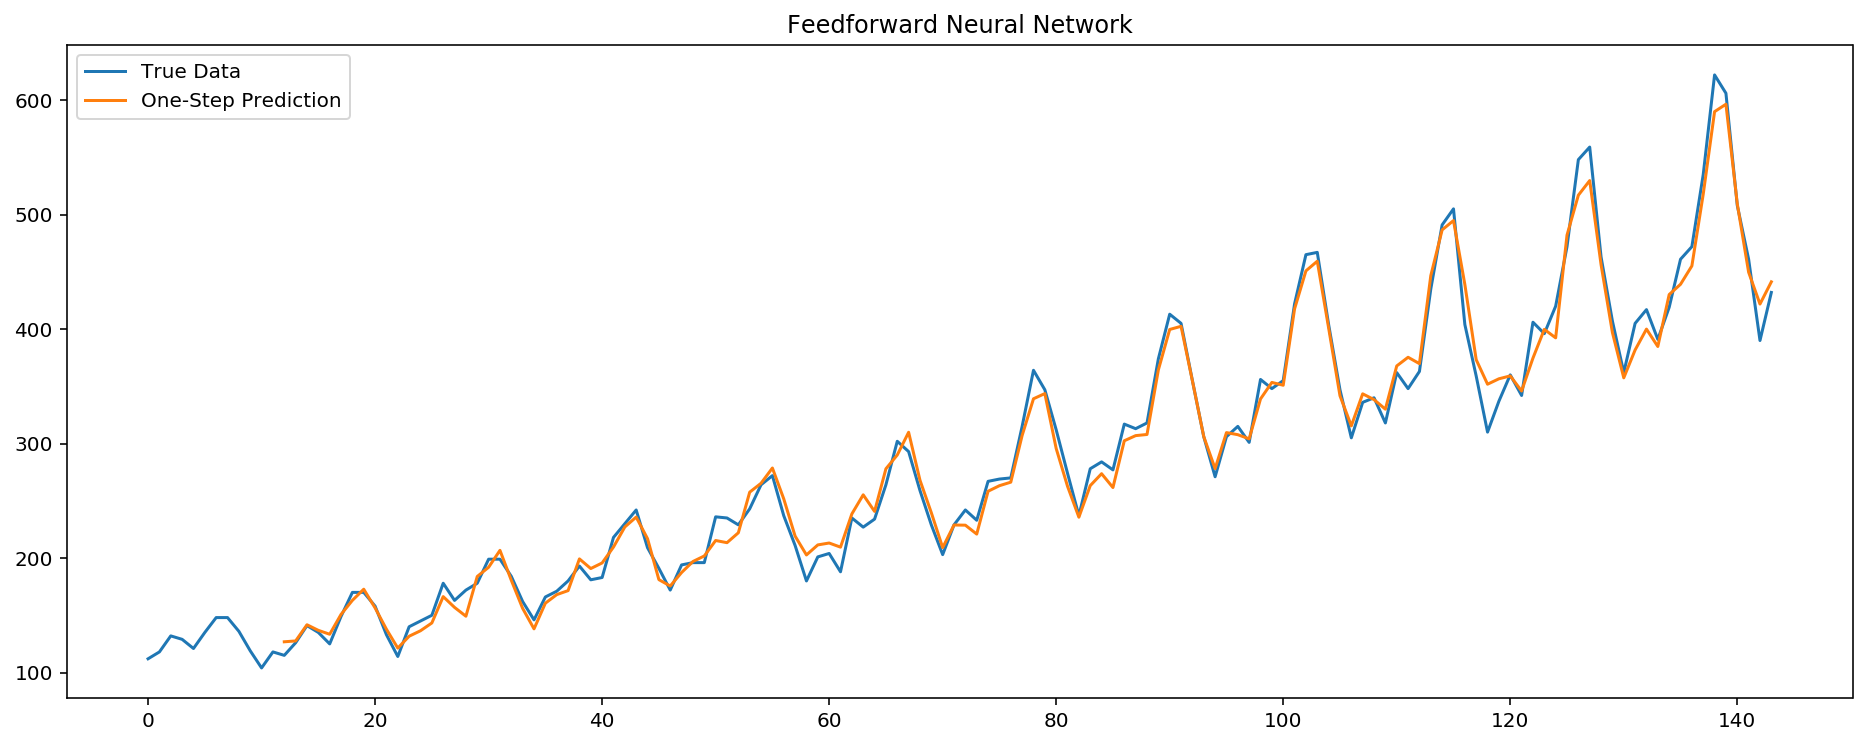

In [17]:
# visualization
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(np.arange(time_window, len(data)), allPredictPlot, label='One-Step Prediction') 
plt.title('Feedforward Neural Network')
plt.legend();

In [18]:
# RMSE
trainScore = math.sqrt(mean_squared_error(Ytrain, allPredict[:train_size,0]))
print('Training Data RMSE: {0:.2f}'.format(trainScore))

Training Data RMSE: 0.02


**Question:**  
What is the purpose of inverse_transform() function?

> undo the scaling according to its feature_range.

### 10.	Dynamic Forecast

In real world, we do not have access to the future values so we have to do a dynamic (or **out of sample**) forecast. This forecast uses observations up to some time point. From that point onwards we append our latest forecast to the list and use a <span class="girk">combination of real values and estimated values</span>. Eventually if the forecast length exceeds the window of values used we will be only using estimated values.

In [19]:
# copy the training set to the new variable
# the result is a ndarray
dynamic_prediction = np.copy(data[:len(data) - test_size]) 

# for the test set range (from the 81% to 100% values)
for i in range(len(data) - test_size, len(data)):
    # locate the input values and reshape them into (1,window_size)
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window))
    # use the latest input values to get the new prediction results
    next_pred = model.predict(last_feature)
    # append the new prediction to the end of variable 'dynamic_prediction'
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

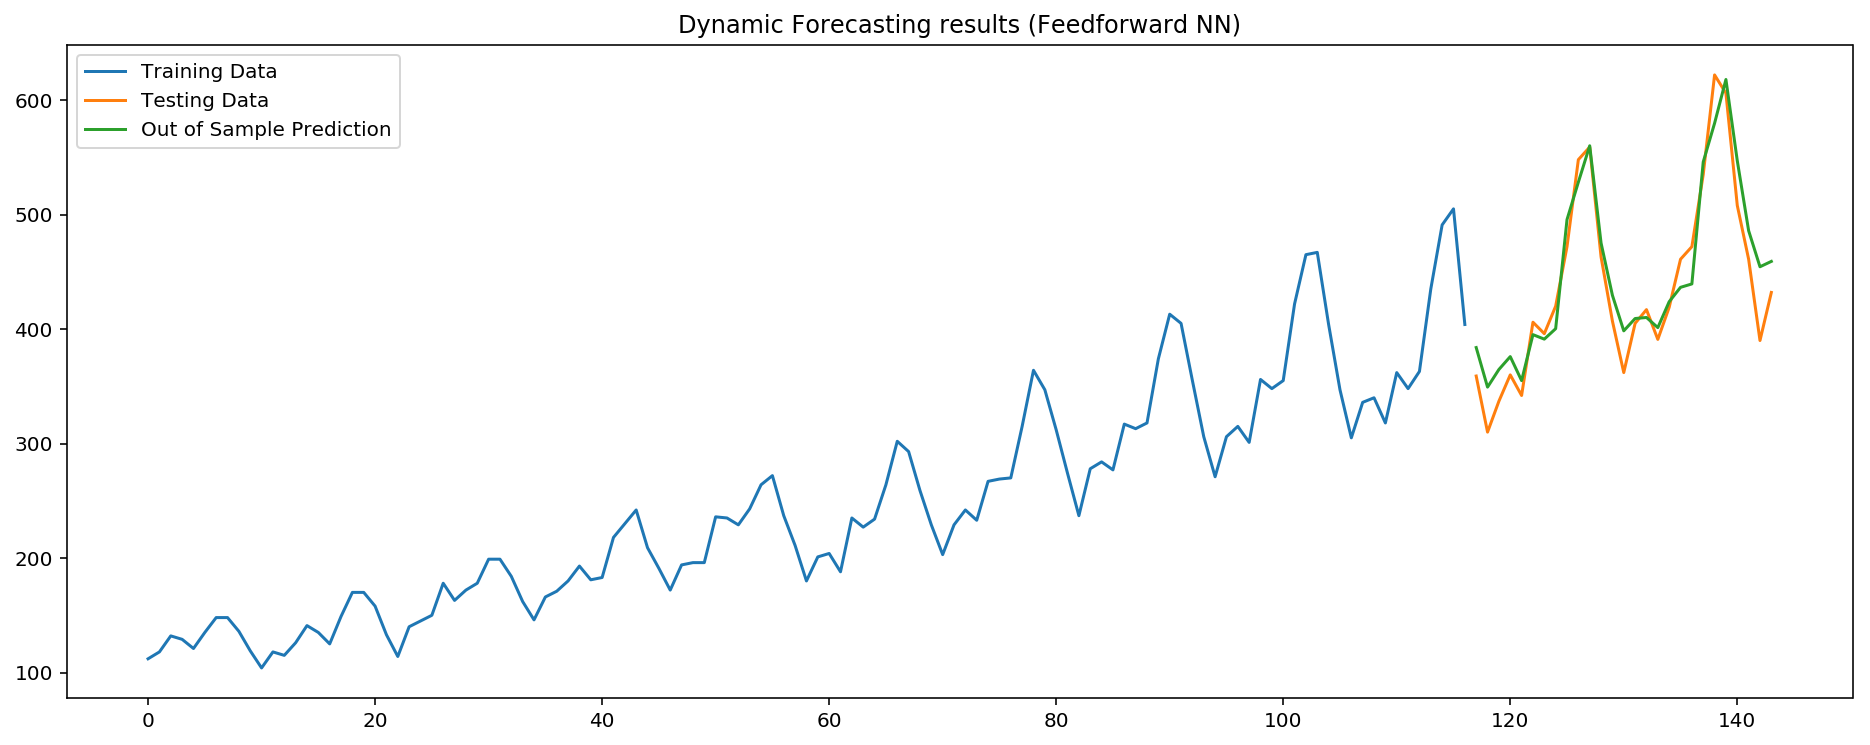

In [133]:
plt.figure()
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), 
         scaler.inverse_transform(data[-test_size:]), 
         label='Testing Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), 
         dynamic_prediction[-test_size:], 
         label='Out of Sample Prediction') 
plt.legend(loc = "upper left")
plt.title('Dynamic Forecasting results (Feedforward NN)');

In [134]:
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(data[-test_size:]), 
                                         dynamic_prediction[-test_size:]))
print('Dynamic Forecast RMSE: {0:.2f}'.format(testScore))

# question: why the RMSE score is significantly different from the last part? (0.02)

Dynamic Forecast RMSE: 25.64


In [ ]:
# RMSE
trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(data[:train_size]), 
                                          allPredictPlot[:train_size,0]))
print('Training Data RMSE: {0:.2f}'.format(trainScore))

## PART 3. Recurrent Neural Network

**Recurrent NN and LSTM (Long-Short Term Memory)**

Currently the network is a conventional feed forward network with one hidden layer.

This conventional design is not optimal for modelling data with <span class="mark">time or spatial dependency</span>. In other words, each input data feature is independent of the other and the relationship between neurons is also independent each other. We have tricked the feed forward network into modelling this relationship by carefully constructing our feature inputs.

In contrast RNNs use a set of more complex neurons that store state over a sequence of inputs. They naturally accept sequences of inputs and can produce sequences as outputs or single values. This is ideal for modeling time series data since the input is a set of sequences and we may wish to produce a sequence of outputs or a single output as our prediction.
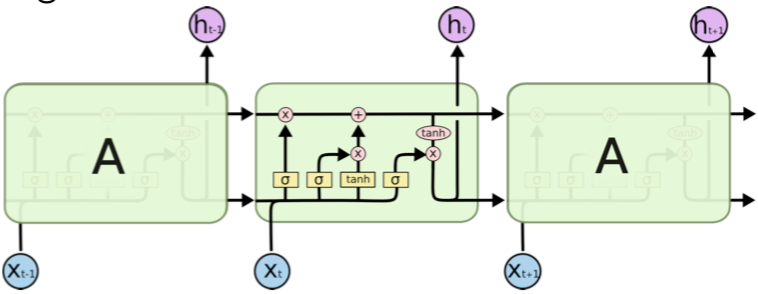
Changing our neural network to use a LSTM layer is relatively straight forward.

In [102]:
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation

### 11.	Modify Parameters

Change the time window length and the fitting arguments.

In [107]:
# define time window
time_window = 20

# reset training / test data for X and Y
Xall, Yall = [], []

for i in range(time_window, len(data)):
    Xall.append(data[i-time_window:i, 0])
    Yall.append(data[i, 0])

# Convert them from list to array 
Xall = np.array(Xall)      
Yall = np.array(Yall)

# we have training : test = 99 : 25
train_size = int(len(Xall) * 0.8)
test_size = len(Xall) - train_size

Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]

Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]

# For time series and LSTM layer we need to reshape into 3D array
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], time_window, 1))  
Xtest = np.reshape(Xtest, (Xtest.shape[0], time_window, 1))  

### 12.	Modify the Model

In [108]:
model = Sequential()

# Add a LSTM with units (number of hidden neurons) = 50
# input_dim = 1 (for time series)
# return sequences = False means only forward the last lagged output to the following layer
model.add(LSTM(input_shape=(None, 1),units=50,return_sequences=False))   # Many-to-One model
model.add(Dense(output_dim=1))
model.add(Activation("linear")) # use linear activation function for the last layer

model.compile(loss = "mse", optimizer = "rmsprop")

**Notes**

Tuning is much more difficult with LSTM since we now have more interacting parameters and a more complex network. Sometimes tuning for your data can take a lot of time. It is part of the skill of using neural networks. Please familiarize yourself with the terminology and how each parameter affects fitting result.

**Units** is the <span class="girk">dimension of the weight vector</span> inside the LSTM “neurons” or cells. Increasing this number can lead to overfitting, decreasing can lead to poor accuracy. You need to make a tradeoff.

**Batch size** is <span class="girk">the number of samples used in each forward/backward pass of the network</span>. You will notice the number of <span class="mark">samples in each Epoch increasing by the batch size</span>.

I find that for time series forecasting increasing the batch size you may get more divergent results (less accuracy) but each Epoch completes quicker.

An **Epoch** is a <span class="girk">forward/backward pass of all batches</span>. If you increase the Epoch’s you should see an improvement in accuracy since it is refining the model parameters each time.

The **validation split** is the proportion of data <span class="mark"><span class="girk">held out for use as validation set</span></span>. As it decreases training accuracy will increase since more training data is available, but the guarantee of generalization is much lower. For small amounts of data and for low epoch’s it is better to keep this number small.

### 13.	Train the model with Early Stopping

Early stopping is a technique to prevent over-training when a monitored quantity has stopped improving.

In [109]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 2, verbose = 1)
# we are going to stop the training process if the loss function did not decrease for 2 iterations

Here, `monitor` is the quantity to be monitored. `patience` is the number of epochs with no improvement after which training will be stopped. If you are interested with further parameter settings in this function, you can refer to https://keras.io/callbacks/#earlystopping 
 
Then, we train the model by calling the `.fit()` function

In [116]:
np.random.seed(1)

# model fitting
model.fit(Xtrain,
          Ytrain,
          batch_size = 5,
          nb_epoch = 20,
          validation_split = 0.1)

# predict all y values and transform back to the original scale
allPredict = model.predict(np.reshape(Xall, (124,20,1)))
allPredict = scaler.inverse_transform(allPredict)

# prepare variables for visualization
allPredictPlot = np.empty_like(data)
allPredictPlot[:, :] = np.nan
allPredictPlot[time_window:, :] = allPredict

Train on 89 samples, validate on 10 samples
Epoch 1/20
89/89 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 2/20
89/89 [==============================] - 1s 11ms/step - loss: 0.0028 - val_loss: 0.0235
Epoch 3/20
89/89 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0299
Epoch 4/20
89/89 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0094
Epoch 5/20
89/89 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 6/20
89/89 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0139
Epoch 7/20
89/89 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 8/20
89/89 [==============================] - 1s 11ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 9/20
89/89 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 10/20
89/89 [==============================] - 1s 9ms/step - lo

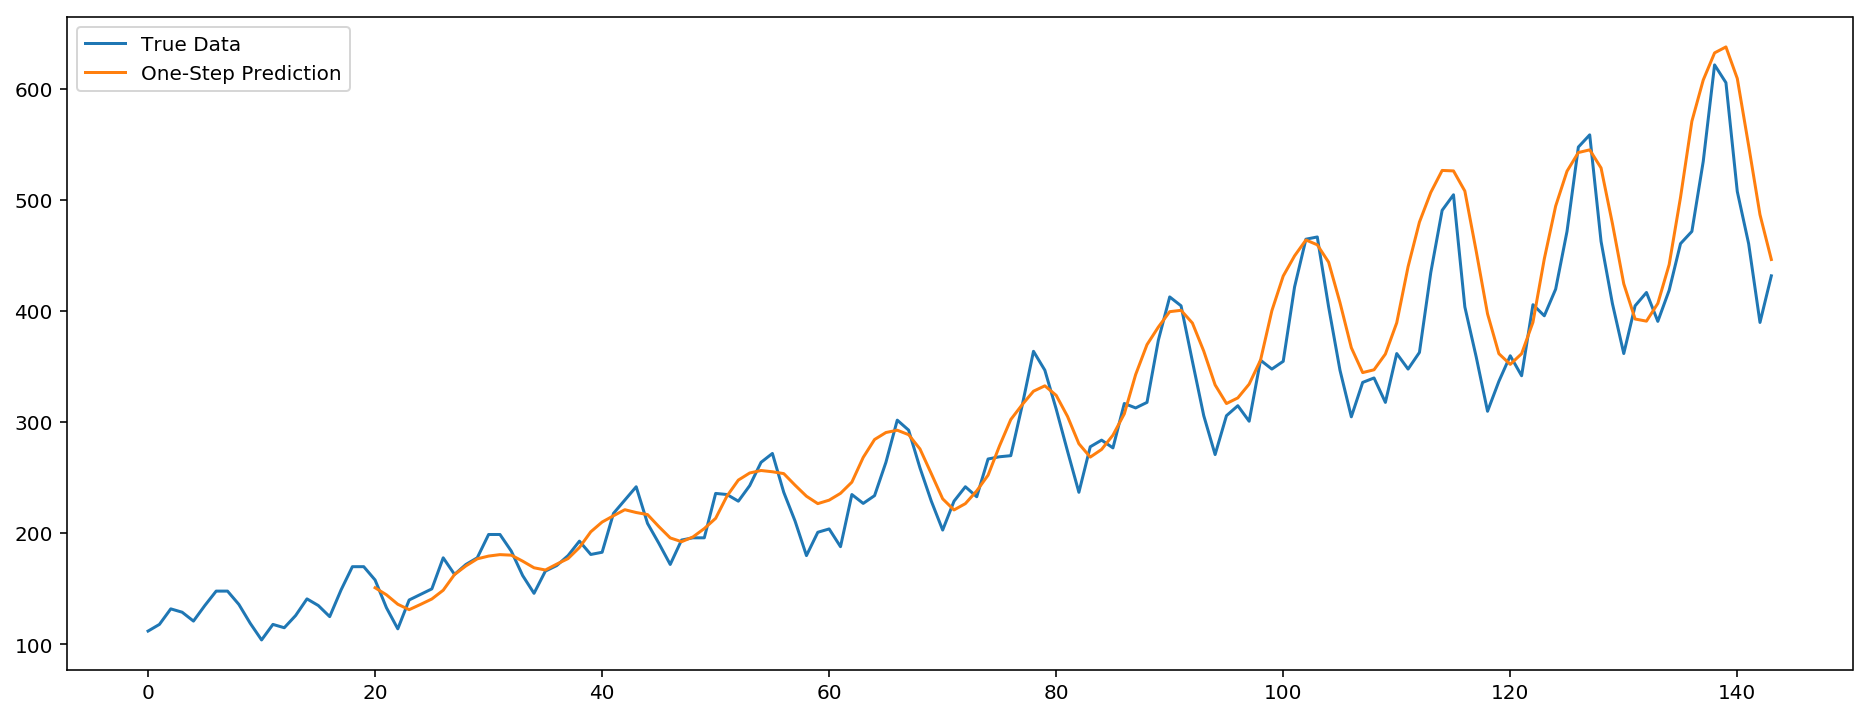

In [118]:
# visualization results
plt.figure()
plt.plot(scaler.inverse_transform(data), label='True Data')
plt.plot(allPredictPlot, label='One-Step Prediction') 
plt.legend()
plt.show()

In [117]:
# RMSE score
trainScore = math.sqrt(mean_squared_error(scaler.inverse_transform(data[:train_size]), 
                                          allPredict[:train_size,0]))
print('Training Data RMSE: {0:.2f}'.format(trainScore))

Training Data RMSE: 91.59


### 14.	Dynamic forecast with LSTM

Finally, we also applied the dynamic forecast with LSTM

In [119]:
dynamic_prediction = np.copy(data[:len(data) - test_size])

for i in range(len(data) - test_size, len(data)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)

# dynamic prediction results, and transform back to the original scale
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction = scaler.inverse_transform(dynamic_prediction)

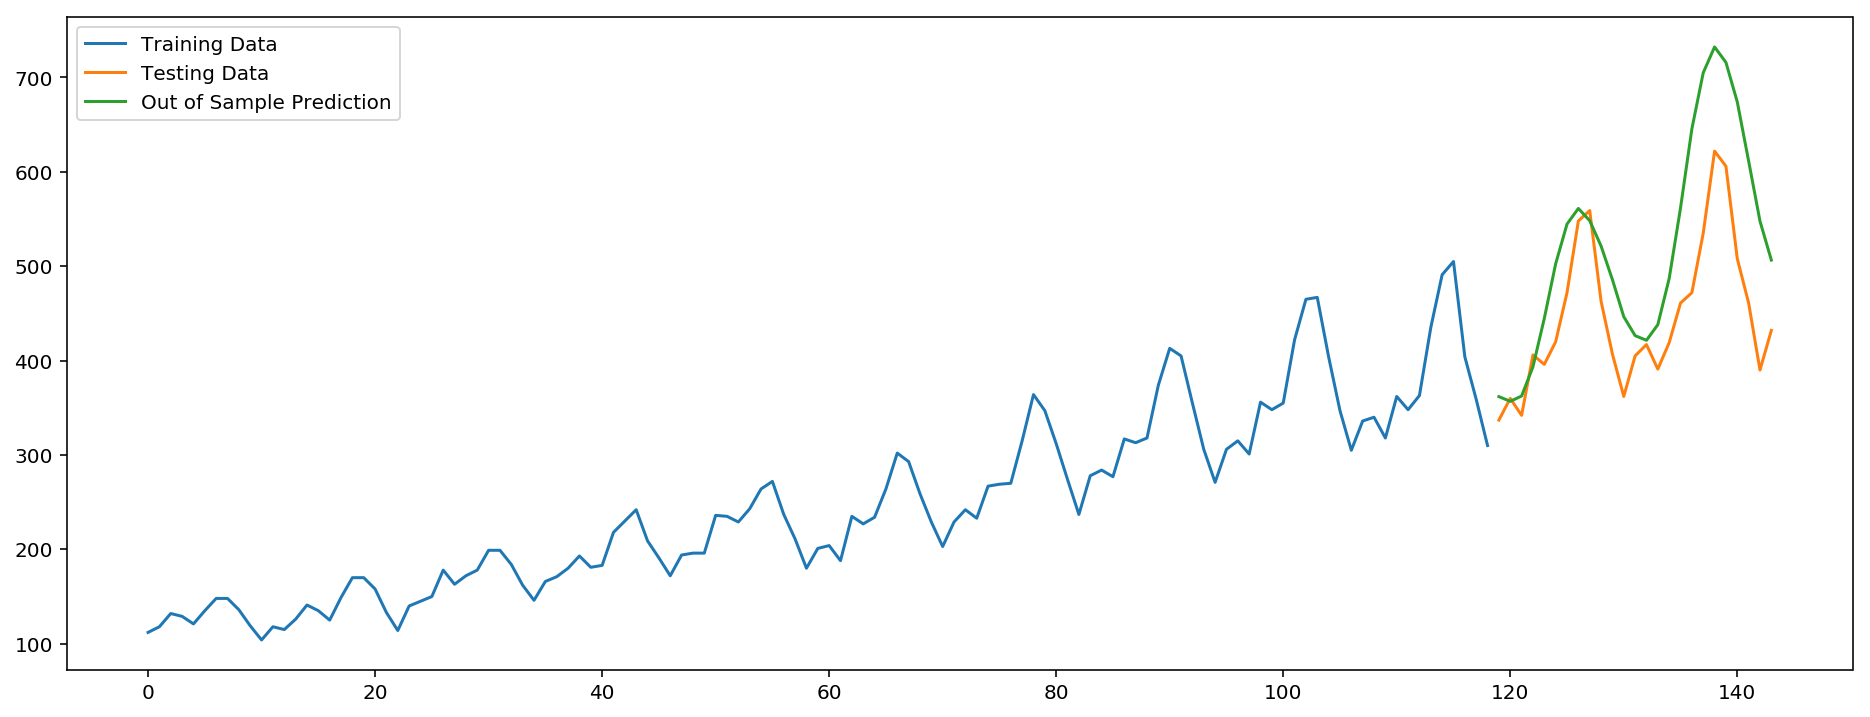

In [120]:
# visualization results
plt.figure()
plt.plot(scaler.inverse_transform(data[:len(data) - test_size]), label='Training Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), 
         scaler.inverse_transform(data[-test_size:]), 
         label='Testing Data')
plt.plot(np.arange(len(data) - test_size, len(data), 1), 
         dynamic_prediction[-test_size:], 
         label='Out of Sample Prediction') 
plt.legend(loc = "upper left")
plt.show();

In [121]:
# RMSE score
testScore = math.sqrt(mean_squared_error(scaler.inverse_transform(data[-test_size:]), 
                                         dynamic_prediction[-test_size:]))
print('Dynamic Forecast RMSE: {0:.2f}'.format(testScore))

Dynamic Forecast RMSE: 92.56


Can you fine-tune the hyper-parameters so that we could obtain a better fitting results?

**Hint**: you can add more hidden layers or increase the number of hidden units. You can also change the windows size and then compare their performance

**key words**  
1. data preprocessing  
`data.values`  
`MinMaxScaler(feature_range=(0, 1))`  
`scaler.fit_transform(data)`  
`scaler.inverse_transform(allPredict)`


2. train_test_split  
`Xtrain = X[:train_size, :]`  
`Ytrain = Y[:train_size]`  


3. Neural Network (1 hidden layer)  
<span class="girk">#define NN structure</span>  
`model = Sequential()`  
`model.add(Dense(hidden_neuron, input_dim = time_window, activation))`  
`model.add(Dense(output_neuron))`   
<span class="girk">#compile</span>  
`model.compile(loss, optimizer)`  
<span class="girk">#model fitting</span>  
`model.fit(Xtrain, Ytrain, epochs, batch_size, validation_split)`  
<span class="girk">#forecasting</span>  
`model.predict(X)`  


4. LSTM      
`model = Sequential()`  
`model.add(LSTM(input_shape=(None, 1), units=50, return_sequences=False))`  
`model.add(Dense(output_dim=1))`  
`model.add(Activation("linear"))`   
`model.compile(loss = "mse", optimizer = "rmsprop")`  
<span class="girk">#early stop</span>  
`EarlyStopping(monitor, patience, verbose = 1)`


5. model evaluation  
`math.sqrt(mean_squared_error(true, predict))`